In [1]:
import torch
from torch.utils.data import sampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import os
import copy
import matplotlib.pyplot as plt

In [2]:
NUM_TRAIN = 49000

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])
cifar10_train = torchvision.datasets.CIFAR10(root='../data/CIFAR10', train=True,
                                           download=True, transform=transform)
loader_train = torch.utils.data.DataLoader(cifar10_train, batch_size=64,
                                      sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
cifar10_val = torchvision.datasets.CIFAR10(root='../data/CIFAR10', train=False,
                                         download=True, transform=transform)
loader_val = torch.utils.data.DataLoader(cifar10_train, batch_size=64,
                                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
cifar10_test = torchvision.datasets.CIFAR10(root='../data/CIFAR10', train=False,
                                         download=True, transform=transform)
loader_test = torch.utils.data.DataLoader(cifar10_train, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_images, train_labels = iter(loader_train).next()
print("train_X:", train_images.size(), "train_y:", train_labels.size())
val_images, val_labels = iter(loader_val).next()
print("val_X:", val_images.size(), "val_y:", val_labels.size())
test_images, test_labels = iter(loader_test).next()
print("test_X:", test_images.size(), "test_y:", test_labels.size())

train_X: torch.Size([64, 3, 32, 32]) train_y: torch.Size([64])
val_X: torch.Size([64, 3, 32, 32]) val_y: torch.Size([64])
test_X: torch.Size([64, 3, 32, 32]) test_y: torch.Size([64])


In [4]:
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('using device', device)

using device cuda


In [5]:
class Model(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, 
                 channel_3, channel_4, num_classes):
        """
        Default initialization:
        model = Model(in_channel=3, channel_1=96, channel_2=192, 
                 channel_3=192, channel_4=192, num_classes=10)
        """
        super().__init__()
        self.conv1_1 = nn.Conv2d(in_channel, channel_1, 3, padding=1)  #(3, 96, 3)
        self.conv1_2 = nn.Conv2d(channel_1, channel_1, 3, padding=1)   #(96, 96, 3)
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv2_1 = nn.Conv2d(channel_1, channel_2, 3, padding=1)   #(96, 192, 3)
        self.conv2_2 = nn.Conv2d(channel_2, channel_2, 3, padding=1)   #(192, 192, 3)
        self.pool2 = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(channel_2, channel_3, 3)   #(192, 192, 3)
        self.conv4 = nn.Conv2d(channel_3, channel_4, 1)   #(192, 192, 1)
        self.conv5 = nn.Conv2d(channel_4, num_classes, 1) #(192, 10, 1)
        
    def forward(self, x):
        """
        x.shape: (64, 3, 32, 32)
        """
        N = x.shape[0]
        x_drop = F.dropout(x, .2)
        conv1_1_out = F.relu(self.conv1_1(x_drop))            # (64, 96, 32, 32)
        conv1_2_out = F.relu(self.conv1_2(conv1_1_out))            # (64, 96, 32, 32)
        layer1_out = self.pool1(conv1_2_out)                      # (64, 96, 16, 16)
        layer1_out_drop = F.dropout(layer1_out, .5)
        conv2_1_out = F.relu(self.conv2_1(layer1_out_drop))   # (64, 192, 16, 16)
        conv2_2_out = F.relu(self.conv2_2(conv2_1_out))   # (64, 192, 16, 16)    
        layer2_out = self.pool2(conv2_2_out)                      # (64, 192, 8, 8)
        layer2_out_drop = F.dropout(layer2_out, .5)
        layer3_out = F.relu(self.conv3(layer2_out_drop))             # (64, 192, 6, 6)
        layer4_out = F.relu(self.conv4(layer3_out))             # (64, 192, 6, 6)
        layer5_out = F.relu(self.conv5(layer4_out))             # (64, 10, 6, 6)
#         print(x.size(), conv1_1_out.size(), conv1_2_out.size(), layer1_out.size(),layer5_out.size())
        out = layer5_out.view(N, 10, -1).mean(dim=2)
        return out
        
def test_Model():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)
    model = Model(in_channel=3, channel_1=96, channel_2=192, 
                 channel_3=192, channel_4=192, num_classes=10)
    scores = model(x)
    print(scores.size())
test_Model()

torch.Size([64, 10])


In [6]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set') 
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc

In [7]:
def plot(x_lst, y_lst, path, name, xlabel, ylabel):
    plt.plot(x_lst, y_lst)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    plt.savefig(path + name)

In [8]:
print_every = 100

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def train(model, optimizer, scheduler, weight_decay=0.001, epochs=1, best_acc=0.0):
    loss_his = []
    epoch_lst = []
    acc_his = []
    
    model = model.to(device=device)
    model = nn.DataParallel(model,device_ids=[0,1])  
    
    for e in range(epochs):
        scheduler.step()
        for step, (x, y) in enumerate(loader_train):
            model.train()
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if step % print_every == 0:
                learning_rate = get_lr(optimizer)
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, step, loss.item()))
                acc = check_accuracy(loader_val, model)
                if acc > best_acc:
                    best_acc = acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                fo = open("model_c.log", "a")
                fo.write("Epoch: {}\t Step: {}\t loss: {:.4f}\t accuracy: {:.2f}\n"\
                         .format(e, step, loss.item(), acc))
                fo.close()
                print()
        epoch_lst.append(e)
        loss_his.append(loss.item())
        acc_his.append(acc)
    
    plot(epoch_lst, loss_his, path="../results figure/", name="Model C_Loss accross Epoch", 
        xlabel="epoch", ylabel="loss")
    plot(epoch_lst, acc_his, path="../results figure/", name="Model C_Accuracy accross Epoch",
        xlabel="epoch", ylabel="accuracy")
                
    print("Best accuracy:", best_acc)
    fo = open("model_c.log", "a")
    fo.write("Best accuracy: {}".format(best_acc))
    fo.close()
    model.load_state_dict(best_model_wts)
    return model

Learning_rate: 0.01
Epoch 0, Iteration 0, loss = 2.3055
Checking accuracy on validation set
Got 113 / 1000 correct (11.30)

Epoch 0, Iteration 100, loss = 2.3017
Checking accuracy on validation set
Got 128 / 1000 correct (12.80)

Epoch 0, Iteration 200, loss = 2.2939
Checking accuracy on validation set
Got 181 / 1000 correct (18.10)

Epoch 0, Iteration 300, loss = 2.2748
Checking accuracy on validation set
Got 154 / 1000 correct (15.40)

Epoch 0, Iteration 400, loss = 2.2026
Checking accuracy on validation set
Got 244 / 1000 correct (24.40)

Epoch 0, Iteration 500, loss = 2.1562
Checking accuracy on validation set
Got 222 / 1000 correct (22.20)

Epoch 0, Iteration 600, loss = 2.2869
Checking accuracy on validation set
Got 266 / 1000 correct (26.60)

Epoch 0, Iteration 700, loss = 2.2579
Checking accuracy on validation set
Got 239 / 1000 correct (23.90)

Epoch 1, Iteration 0, loss = 2.1029
Checking accuracy on validation set
Got 287 / 1000 correct (28.70)

Epoch 1, Iteration 100, loss =

Got 777 / 1000 correct (77.70)

Epoch 9, Iteration 600, loss = 0.7094
Checking accuracy on validation set
Got 788 / 1000 correct (78.80)

Epoch 9, Iteration 700, loss = 0.6898
Checking accuracy on validation set
Got 795 / 1000 correct (79.50)

Epoch 10, Iteration 0, loss = 0.5438
Checking accuracy on validation set
Got 772 / 1000 correct (77.20)

Epoch 10, Iteration 100, loss = 0.6737
Checking accuracy on validation set
Got 761 / 1000 correct (76.10)

Epoch 10, Iteration 200, loss = 0.6044
Checking accuracy on validation set
Got 756 / 1000 correct (75.60)

Epoch 10, Iteration 300, loss = 0.6426
Checking accuracy on validation set
Got 790 / 1000 correct (79.00)

Epoch 10, Iteration 400, loss = 0.4796
Checking accuracy on validation set
Got 776 / 1000 correct (77.60)

Epoch 10, Iteration 500, loss = 0.4813
Checking accuracy on validation set
Got 793 / 1000 correct (79.30)

Epoch 10, Iteration 600, loss = 0.3404
Checking accuracy on validation set
Got 802 / 1000 correct (80.20)

Epoch 10,

Got 835 / 1000 correct (83.50)

Epoch 19, Iteration 300, loss = 0.3443
Checking accuracy on validation set
Got 817 / 1000 correct (81.70)

Epoch 19, Iteration 400, loss = 0.2310
Checking accuracy on validation set
Got 825 / 1000 correct (82.50)

Epoch 19, Iteration 500, loss = 0.2658
Checking accuracy on validation set
Got 840 / 1000 correct (84.00)

Epoch 19, Iteration 600, loss = 0.3575
Checking accuracy on validation set
Got 824 / 1000 correct (82.40)

Epoch 19, Iteration 700, loss = 0.2512
Checking accuracy on validation set
Got 834 / 1000 correct (83.40)

Epoch 20, Iteration 0, loss = 0.1488
Checking accuracy on validation set
Got 822 / 1000 correct (82.20)

Epoch 20, Iteration 100, loss = 0.1507
Checking accuracy on validation set
Got 830 / 1000 correct (83.00)

Epoch 20, Iteration 200, loss = 0.1856
Checking accuracy on validation set
Got 831 / 1000 correct (83.10)

Epoch 20, Iteration 300, loss = 0.2304
Checking accuracy on validation set
Got 818 / 1000 correct (81.80)

Epoch 2

Got 845 / 1000 correct (84.50)

Epoch 29, Iteration 0, loss = 0.0865
Checking accuracy on validation set
Got 807 / 1000 correct (80.70)

Epoch 29, Iteration 100, loss = 0.1014
Checking accuracy on validation set
Got 847 / 1000 correct (84.70)

Epoch 29, Iteration 200, loss = 0.0910
Checking accuracy on validation set
Got 835 / 1000 correct (83.50)

Epoch 29, Iteration 300, loss = 0.0499
Checking accuracy on validation set
Got 852 / 1000 correct (85.20)

Epoch 29, Iteration 400, loss = 0.1940
Checking accuracy on validation set
Got 841 / 1000 correct (84.10)

Epoch 29, Iteration 500, loss = 0.1850
Checking accuracy on validation set
Got 830 / 1000 correct (83.00)

Epoch 29, Iteration 600, loss = 0.1085
Checking accuracy on validation set
Got 829 / 1000 correct (82.90)

Epoch 29, Iteration 700, loss = 0.2585
Checking accuracy on validation set
Got 842 / 1000 correct (84.20)

Epoch 30, Iteration 0, loss = 0.1294
Checking accuracy on validation set
Got 840 / 1000 correct (84.00)

Epoch 30,

Got 841 / 1000 correct (84.10)

Epoch 38, Iteration 500, loss = 0.0246
Checking accuracy on validation set
Got 844 / 1000 correct (84.40)

Epoch 38, Iteration 600, loss = 0.1179
Checking accuracy on validation set
Got 813 / 1000 correct (81.30)

Epoch 38, Iteration 700, loss = 0.2156
Checking accuracy on validation set
Got 835 / 1000 correct (83.50)

Epoch 39, Iteration 0, loss = 0.1711
Checking accuracy on validation set
Got 823 / 1000 correct (82.30)

Epoch 39, Iteration 100, loss = 0.0459
Checking accuracy on validation set
Got 839 / 1000 correct (83.90)

Epoch 39, Iteration 200, loss = 0.0771
Checking accuracy on validation set
Got 847 / 1000 correct (84.70)

Epoch 39, Iteration 300, loss = 0.0437
Checking accuracy on validation set
Got 852 / 1000 correct (85.20)

Epoch 39, Iteration 400, loss = 0.0516
Checking accuracy on validation set
Got 836 / 1000 correct (83.60)

Epoch 39, Iteration 500, loss = 0.1643
Checking accuracy on validation set
Got 829 / 1000 correct (82.90)

Epoch 3

Got 849 / 1000 correct (84.90)

Epoch 48, Iteration 200, loss = 0.0712
Checking accuracy on validation set
Got 833 / 1000 correct (83.30)

Epoch 48, Iteration 300, loss = 0.0768
Checking accuracy on validation set
Got 834 / 1000 correct (83.40)

Epoch 48, Iteration 400, loss = 0.1117
Checking accuracy on validation set
Got 850 / 1000 correct (85.00)

Epoch 48, Iteration 500, loss = 0.0634
Checking accuracy on validation set
Got 841 / 1000 correct (84.10)

Epoch 48, Iteration 600, loss = 0.0524
Checking accuracy on validation set
Got 836 / 1000 correct (83.60)

Epoch 48, Iteration 700, loss = 0.1132
Checking accuracy on validation set
Got 821 / 1000 correct (82.10)

Epoch 49, Iteration 0, loss = 0.0486
Checking accuracy on validation set
Got 831 / 1000 correct (83.10)

Epoch 49, Iteration 100, loss = 0.0607
Checking accuracy on validation set
Got 795 / 1000 correct (79.50)

Epoch 49, Iteration 200, loss = 0.1369
Checking accuracy on validation set
Got 829 / 1000 correct (82.90)

Epoch 4

Got 844 / 1000 correct (84.40)

Epoch 57, Iteration 700, loss = 0.1118
Checking accuracy on validation set
Got 837 / 1000 correct (83.70)

Epoch 58, Iteration 0, loss = 0.0910
Checking accuracy on validation set
Got 829 / 1000 correct (82.90)

Epoch 58, Iteration 100, loss = 0.0391
Checking accuracy on validation set
Got 829 / 1000 correct (82.90)

Epoch 58, Iteration 200, loss = 0.0975
Checking accuracy on validation set
Got 847 / 1000 correct (84.70)

Epoch 58, Iteration 300, loss = 0.0265
Checking accuracy on validation set
Got 823 / 1000 correct (82.30)

Epoch 58, Iteration 400, loss = 0.0174
Checking accuracy on validation set
Got 846 / 1000 correct (84.60)

Epoch 58, Iteration 500, loss = 0.0812
Checking accuracy on validation set
Got 843 / 1000 correct (84.30)

Epoch 58, Iteration 600, loss = 0.0324
Checking accuracy on validation set
Got 824 / 1000 correct (82.40)

Epoch 58, Iteration 700, loss = 0.0998
Checking accuracy on validation set
Got 845 / 1000 correct (84.50)

Epoch 5

Got 842 / 1000 correct (84.20)

Epoch 67, Iteration 400, loss = 0.1037
Checking accuracy on validation set
Got 834 / 1000 correct (83.40)

Epoch 67, Iteration 500, loss = 0.0599
Checking accuracy on validation set
Got 827 / 1000 correct (82.70)

Epoch 67, Iteration 600, loss = 0.0994
Checking accuracy on validation set
Got 798 / 1000 correct (79.80)

Epoch 67, Iteration 700, loss = 0.0827
Checking accuracy on validation set
Got 827 / 1000 correct (82.70)

Epoch 68, Iteration 0, loss = 0.0447
Checking accuracy on validation set
Got 843 / 1000 correct (84.30)

Epoch 68, Iteration 100, loss = 0.0528
Checking accuracy on validation set
Got 851 / 1000 correct (85.10)

Epoch 68, Iteration 200, loss = 0.1100
Checking accuracy on validation set
Got 858 / 1000 correct (85.80)

Epoch 68, Iteration 300, loss = 0.0980
Checking accuracy on validation set
Got 845 / 1000 correct (84.50)

Epoch 68, Iteration 400, loss = 0.1873
Checking accuracy on validation set
Got 824 / 1000 correct (82.40)

Epoch 6

Got 807 / 1000 correct (80.70)

Epoch 77, Iteration 100, loss = 0.0297
Checking accuracy on validation set
Got 832 / 1000 correct (83.20)

Epoch 77, Iteration 200, loss = 0.0320
Checking accuracy on validation set
Got 844 / 1000 correct (84.40)

Epoch 77, Iteration 300, loss = 0.1667
Checking accuracy on validation set
Got 850 / 1000 correct (85.00)

Epoch 77, Iteration 400, loss = 0.0841
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Epoch 77, Iteration 500, loss = 0.0563
Checking accuracy on validation set
Got 850 / 1000 correct (85.00)

Epoch 77, Iteration 600, loss = 0.2202
Checking accuracy on validation set
Got 835 / 1000 correct (83.50)

Epoch 77, Iteration 700, loss = 0.1737
Checking accuracy on validation set
Got 834 / 1000 correct (83.40)

Epoch 78, Iteration 0, loss = 0.0323
Checking accuracy on validation set
Got 848 / 1000 correct (84.80)

Epoch 78, Iteration 100, loss = 0.0923
Checking accuracy on validation set
Got 852 / 1000 correct (85.20)

Epoch 7

Got 839 / 1000 correct (83.90)

Epoch 86, Iteration 600, loss = 0.0540
Checking accuracy on validation set
Got 824 / 1000 correct (82.40)

Epoch 86, Iteration 700, loss = 0.1530
Checking accuracy on validation set
Got 817 / 1000 correct (81.70)

Epoch 87, Iteration 0, loss = 0.0740
Checking accuracy on validation set
Got 830 / 1000 correct (83.00)

Epoch 87, Iteration 100, loss = 0.1088
Checking accuracy on validation set
Got 858 / 1000 correct (85.80)

Epoch 87, Iteration 200, loss = 0.0389
Checking accuracy on validation set
Got 843 / 1000 correct (84.30)

Epoch 87, Iteration 300, loss = 0.0289
Checking accuracy on validation set
Got 839 / 1000 correct (83.90)

Epoch 87, Iteration 400, loss = 0.0632
Checking accuracy on validation set
Got 832 / 1000 correct (83.20)

Epoch 87, Iteration 500, loss = 0.0860
Checking accuracy on validation set
Got 843 / 1000 correct (84.30)

Epoch 87, Iteration 600, loss = 0.0555
Checking accuracy on validation set
Got 819 / 1000 correct (81.90)

Epoch 8

Got 857 / 1000 correct (85.70)

Epoch 96, Iteration 300, loss = 0.0423
Checking accuracy on validation set
Got 831 / 1000 correct (83.10)

Epoch 96, Iteration 400, loss = 0.0881
Checking accuracy on validation set
Got 847 / 1000 correct (84.70)

Epoch 96, Iteration 500, loss = 0.1286
Checking accuracy on validation set
Got 845 / 1000 correct (84.50)

Epoch 96, Iteration 600, loss = 0.0880
Checking accuracy on validation set
Got 832 / 1000 correct (83.20)

Epoch 96, Iteration 700, loss = 0.1429
Checking accuracy on validation set
Got 832 / 1000 correct (83.20)

Epoch 97, Iteration 0, loss = 0.0424
Checking accuracy on validation set
Got 849 / 1000 correct (84.90)

Epoch 97, Iteration 100, loss = 0.0708
Checking accuracy on validation set
Got 813 / 1000 correct (81.30)

Epoch 97, Iteration 200, loss = 0.0345
Checking accuracy on validation set
Got 854 / 1000 correct (85.40)

Epoch 97, Iteration 300, loss = 0.0692
Checking accuracy on validation set
Got 842 / 1000 correct (84.20)

Epoch 9

Epoch 105, Iteration 700, loss = 0.0497
Checking accuracy on validation set
Got 841 / 1000 correct (84.10)

Epoch 106, Iteration 0, loss = 0.0625
Checking accuracy on validation set
Got 825 / 1000 correct (82.50)

Epoch 106, Iteration 100, loss = 0.1244
Checking accuracy on validation set
Got 830 / 1000 correct (83.00)

Epoch 106, Iteration 200, loss = 0.0253
Checking accuracy on validation set
Got 851 / 1000 correct (85.10)

Epoch 106, Iteration 300, loss = 0.1008
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Epoch 106, Iteration 400, loss = 0.1796
Checking accuracy on validation set
Got 845 / 1000 correct (84.50)

Epoch 106, Iteration 500, loss = 0.1451
Checking accuracy on validation set
Got 840 / 1000 correct (84.00)

Epoch 106, Iteration 600, loss = 0.0742
Checking accuracy on validation set
Got 845 / 1000 correct (84.50)

Epoch 106, Iteration 700, loss = 0.0871
Checking accuracy on validation set
Got 836 / 1000 correct (83.60)

Epoch 107, Iteration 0, loss =

Got 852 / 1000 correct (85.20)

Epoch 115, Iteration 400, loss = 0.0956
Checking accuracy on validation set
Got 841 / 1000 correct (84.10)

Epoch 115, Iteration 500, loss = 0.0859
Checking accuracy on validation set
Got 846 / 1000 correct (84.60)

Epoch 115, Iteration 600, loss = 0.0653
Checking accuracy on validation set
Got 855 / 1000 correct (85.50)

Epoch 115, Iteration 700, loss = 0.0677
Checking accuracy on validation set
Got 845 / 1000 correct (84.50)

Epoch 116, Iteration 0, loss = 0.0445
Checking accuracy on validation set
Got 840 / 1000 correct (84.00)

Epoch 116, Iteration 100, loss = 0.0600
Checking accuracy on validation set
Got 830 / 1000 correct (83.00)

Epoch 116, Iteration 200, loss = 0.0471
Checking accuracy on validation set
Got 842 / 1000 correct (84.20)

Epoch 116, Iteration 300, loss = 0.0278
Checking accuracy on validation set
Got 851 / 1000 correct (85.10)

Epoch 116, Iteration 400, loss = 0.1145
Checking accuracy on validation set
Got 819 / 1000 correct (81.90)

Epoch 125, Iteration 0, loss = 0.0953
Checking accuracy on validation set
Got 829 / 1000 correct (82.90)

Epoch 125, Iteration 100, loss = 0.0301
Checking accuracy on validation set
Got 846 / 1000 correct (84.60)

Epoch 125, Iteration 200, loss = 0.0343
Checking accuracy on validation set
Got 858 / 1000 correct (85.80)

Epoch 125, Iteration 300, loss = 0.1048
Checking accuracy on validation set
Got 831 / 1000 correct (83.10)

Epoch 125, Iteration 400, loss = 0.0188
Checking accuracy on validation set
Got 848 / 1000 correct (84.80)

Epoch 125, Iteration 500, loss = 0.1016
Checking accuracy on validation set
Got 833 / 1000 correct (83.30)

Epoch 125, Iteration 600, loss = 0.0918
Checking accuracy on validation set
Got 844 / 1000 correct (84.40)

Epoch 125, Iteration 700, loss = 0.0363
Checking accuracy on validation set
Got 849 / 1000 correct (84.90)

Epoch 126, Iteration 0, loss = 0.1409
Checking accuracy on validation set
Got 800 / 1000 correct (80.00)

Epoch 126, Iteration 100, loss =

Got 857 / 1000 correct (85.70)

Epoch 134, Iteration 500, loss = 0.0363
Checking accuracy on validation set
Got 835 / 1000 correct (83.50)

Epoch 134, Iteration 600, loss = 0.1259
Checking accuracy on validation set
Got 843 / 1000 correct (84.30)

Epoch 134, Iteration 700, loss = 0.0791
Checking accuracy on validation set
Got 855 / 1000 correct (85.50)

Epoch 135, Iteration 0, loss = 0.0885
Checking accuracy on validation set
Got 853 / 1000 correct (85.30)

Epoch 135, Iteration 100, loss = 0.0803
Checking accuracy on validation set
Got 846 / 1000 correct (84.60)

Epoch 135, Iteration 200, loss = 0.0347
Checking accuracy on validation set
Got 843 / 1000 correct (84.30)

Epoch 135, Iteration 300, loss = 0.0327
Checking accuracy on validation set
Got 833 / 1000 correct (83.30)

Epoch 135, Iteration 400, loss = 0.0757
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Epoch 135, Iteration 500, loss = 0.0531
Checking accuracy on validation set
Got 841 / 1000 correct (84.10)

Epoch 144, Iteration 100, loss = 0.0905
Checking accuracy on validation set
Got 846 / 1000 correct (84.60)

Epoch 144, Iteration 200, loss = 0.0389
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Epoch 144, Iteration 300, loss = 0.0604
Checking accuracy on validation set
Got 849 / 1000 correct (84.90)

Epoch 144, Iteration 400, loss = 0.1249
Checking accuracy on validation set
Got 841 / 1000 correct (84.10)

Epoch 144, Iteration 500, loss = 0.1064
Checking accuracy on validation set
Got 850 / 1000 correct (85.00)

Epoch 144, Iteration 600, loss = 0.0237
Checking accuracy on validation set
Got 847 / 1000 correct (84.70)

Epoch 144, Iteration 700, loss = 0.0765
Checking accuracy on validation set
Got 847 / 1000 correct (84.70)

Epoch 145, Iteration 0, loss = 0.0620
Checking accuracy on validation set
Got 852 / 1000 correct (85.20)

Epoch 145, Iteration 100, loss = 0.0260
Checking accuracy on validation set
Got 853 / 1000 correct (85.30)

Epoch 145, Iteration 200, loss

Got 849 / 1000 correct (84.90)

Epoch 153, Iteration 600, loss = 0.0379
Checking accuracy on validation set
Got 847 / 1000 correct (84.70)

Epoch 153, Iteration 700, loss = 0.0440
Checking accuracy on validation set
Got 836 / 1000 correct (83.60)

Epoch 154, Iteration 0, loss = 0.1593
Checking accuracy on validation set
Got 845 / 1000 correct (84.50)

Epoch 154, Iteration 100, loss = 0.0483
Checking accuracy on validation set
Got 857 / 1000 correct (85.70)

Epoch 154, Iteration 200, loss = 0.0619
Checking accuracy on validation set
Got 840 / 1000 correct (84.00)

Epoch 154, Iteration 300, loss = 0.0141
Checking accuracy on validation set
Got 859 / 1000 correct (85.90)

Epoch 154, Iteration 400, loss = 0.0720
Checking accuracy on validation set
Got 837 / 1000 correct (83.70)

Epoch 154, Iteration 500, loss = 0.0950
Checking accuracy on validation set
Got 841 / 1000 correct (84.10)

Epoch 154, Iteration 600, loss = 0.0739
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Epoch 163, Iteration 200, loss = 0.1077
Checking accuracy on validation set
Got 822 / 1000 correct (82.20)

Epoch 163, Iteration 300, loss = 0.0748
Checking accuracy on validation set
Got 854 / 1000 correct (85.40)

Epoch 163, Iteration 400, loss = 0.0364
Checking accuracy on validation set
Got 847 / 1000 correct (84.70)

Epoch 163, Iteration 500, loss = 0.1590
Checking accuracy on validation set
Got 857 / 1000 correct (85.70)

Epoch 163, Iteration 600, loss = 0.0731
Checking accuracy on validation set
Got 853 / 1000 correct (85.30)

Epoch 163, Iteration 700, loss = 0.0787
Checking accuracy on validation set
Got 856 / 1000 correct (85.60)

Epoch 164, Iteration 0, loss = 0.0214
Checking accuracy on validation set
Got 852 / 1000 correct (85.20)

Epoch 164, Iteration 100, loss = 0.0257
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Epoch 164, Iteration 200, loss = 0.1763
Checking accuracy on validation set
Got 845 / 1000 correct (84.50)

Epoch 164, Iteration 300, loss

Got 853 / 1000 correct (85.30)

Epoch 172, Iteration 700, loss = 0.1073
Checking accuracy on validation set
Got 841 / 1000 correct (84.10)

Epoch 173, Iteration 0, loss = 0.0393
Checking accuracy on validation set
Got 830 / 1000 correct (83.00)

Epoch 173, Iteration 100, loss = 0.1757
Checking accuracy on validation set
Got 818 / 1000 correct (81.80)

Epoch 173, Iteration 200, loss = 0.0761
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Epoch 173, Iteration 300, loss = 0.0345
Checking accuracy on validation set
Got 848 / 1000 correct (84.80)

Epoch 173, Iteration 400, loss = 0.0330
Checking accuracy on validation set
Got 845 / 1000 correct (84.50)

Epoch 173, Iteration 500, loss = 0.0437
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Epoch 173, Iteration 600, loss = 0.0642
Checking accuracy on validation set
Got 833 / 1000 correct (83.30)

Epoch 173, Iteration 700, loss = 0.0370
Checking accuracy on validation set
Got 840 / 1000 correct (84.00)

Epoch 182, Iteration 300, loss = 0.0328
Checking accuracy on validation set
Got 851 / 1000 correct (85.10)

Epoch 182, Iteration 400, loss = 0.0350
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Epoch 182, Iteration 500, loss = 0.0150
Checking accuracy on validation set
Got 841 / 1000 correct (84.10)

Epoch 182, Iteration 600, loss = 0.0445
Checking accuracy on validation set
Got 817 / 1000 correct (81.70)

Epoch 182, Iteration 700, loss = 0.1948
Checking accuracy on validation set
Got 828 / 1000 correct (82.80)

Epoch 183, Iteration 0, loss = 0.1148
Checking accuracy on validation set
Got 828 / 1000 correct (82.80)

Epoch 183, Iteration 100, loss = 0.0285
Checking accuracy on validation set
Got 851 / 1000 correct (85.10)

Epoch 183, Iteration 200, loss = 0.0284
Checking accuracy on validation set
Got 853 / 1000 correct (85.30)

Epoch 183, Iteration 300, loss = 0.1078
Checking accuracy on validation set
Got 865 / 1000 correct (86.50)

Epoch 183, Iteration 400, loss

Got 828 / 1000 correct (82.80)

Epoch 192, Iteration 0, loss = 0.0972
Checking accuracy on validation set
Got 842 / 1000 correct (84.20)

Epoch 192, Iteration 100, loss = 0.0503
Checking accuracy on validation set
Got 821 / 1000 correct (82.10)

Epoch 192, Iteration 200, loss = 0.0683
Checking accuracy on validation set
Got 834 / 1000 correct (83.40)

Epoch 192, Iteration 300, loss = 0.0534
Checking accuracy on validation set
Got 850 / 1000 correct (85.00)

Epoch 192, Iteration 400, loss = 0.0270
Checking accuracy on validation set
Got 840 / 1000 correct (84.00)

Epoch 192, Iteration 500, loss = 0.0205
Checking accuracy on validation set
Got 857 / 1000 correct (85.70)

Epoch 192, Iteration 600, loss = 0.1285
Checking accuracy on validation set
Got 854 / 1000 correct (85.40)

Epoch 192, Iteration 700, loss = 0.1012
Checking accuracy on validation set
Got 839 / 1000 correct (83.90)

Epoch 193, Iteration 0, loss = 0.2384
Checking accuracy on validation set
Got 857 / 1000 correct (85.70)



Epoch 201, Iteration 400, loss = 0.0023
Checking accuracy on validation set
Got 864 / 1000 correct (86.40)

Epoch 201, Iteration 500, loss = 0.0057
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Epoch 201, Iteration 600, loss = 0.0069
Checking accuracy on validation set
Got 858 / 1000 correct (85.80)

Epoch 201, Iteration 700, loss = 0.0075
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Epoch 202, Iteration 0, loss = 0.0020
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Epoch 202, Iteration 100, loss = 0.0048
Checking accuracy on validation set
Got 862 / 1000 correct (86.20)

Epoch 202, Iteration 200, loss = 0.0031
Checking accuracy on validation set
Got 861 / 1000 correct (86.10)

Epoch 202, Iteration 300, loss = 0.0034
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Epoch 202, Iteration 400, loss = 0.0090
Checking accuracy on validation set
Got 860 / 1000 correct (86.00)

Epoch 202, Iteration 500, loss

Got 870 / 1000 correct (87.00)

Epoch 211, Iteration 100, loss = 0.0047
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Epoch 211, Iteration 200, loss = 0.0009
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Epoch 211, Iteration 300, loss = 0.0070
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Epoch 211, Iteration 400, loss = 0.0016
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Epoch 211, Iteration 500, loss = 0.0048
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Epoch 211, Iteration 600, loss = 0.0072
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Epoch 211, Iteration 700, loss = 0.0026
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Epoch 212, Iteration 0, loss = 0.0020
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Epoch 212, Iteration 100, loss = 0.0034
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 220, Iteration 500, loss = 0.0066
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Epoch 220, Iteration 600, loss = 0.0040
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Epoch 220, Iteration 700, loss = 0.0092
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Epoch 221, Iteration 0, loss = 0.0071
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Epoch 221, Iteration 100, loss = 0.0095
Checking accuracy on validation set
Got 866 / 1000 correct (86.60)

Epoch 221, Iteration 200, loss = 0.0049
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Epoch 221, Iteration 300, loss = 0.0097
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Epoch 221, Iteration 400, loss = 0.0066
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 221, Iteration 500, loss = 0.0079
Checking accuracy on validation set
Got 867 / 1000 correct (86.70)

Epoch 221, Iteration 600, loss

Got 871 / 1000 correct (87.10)

Epoch 230, Iteration 200, loss = 0.0103
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Epoch 230, Iteration 300, loss = 0.0050
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Epoch 230, Iteration 400, loss = 0.0128
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Epoch 230, Iteration 500, loss = 0.0100
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Epoch 230, Iteration 600, loss = 0.0071
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 230, Iteration 700, loss = 0.0091
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Epoch 231, Iteration 0, loss = 0.0111
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Epoch 231, Iteration 100, loss = 0.0136
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Epoch 231, Iteration 200, loss = 0.0048
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 239, Iteration 600, loss = 0.0071
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Epoch 239, Iteration 700, loss = 0.0079
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Epoch 240, Iteration 0, loss = 0.0085
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Epoch 240, Iteration 100, loss = 0.0085
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Epoch 240, Iteration 200, loss = 0.0115
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Epoch 240, Iteration 300, loss = 0.0075
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Epoch 240, Iteration 400, loss = 0.0134
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 240, Iteration 500, loss = 0.0098
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Epoch 240, Iteration 600, loss = 0.0073
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 240, Iteration 700, loss

Got 875 / 1000 correct (87.50)

Epoch 249, Iteration 300, loss = 0.0051
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Epoch 249, Iteration 400, loss = 0.0113
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Epoch 249, Iteration 500, loss = 0.0086
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 249, Iteration 600, loss = 0.0076
Checking accuracy on validation set
Got 877 / 1000 correct (87.70)

Epoch 249, Iteration 700, loss = 0.0121
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 250, Iteration 0, loss = 0.0105
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 250, Iteration 100, loss = 0.0078
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 250, Iteration 200, loss = 0.0040
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 250, Iteration 300, loss = 0.0054
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Epoch 258, Iteration 700, loss = 0.0144
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 259, Iteration 0, loss = 0.0089
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 259, Iteration 100, loss = 0.0085
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 259, Iteration 200, loss = 0.0081
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Epoch 259, Iteration 300, loss = 0.0112
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 259, Iteration 400, loss = 0.0114
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 259, Iteration 500, loss = 0.0091
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Epoch 259, Iteration 600, loss = 0.0101
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 259, Iteration 700, loss = 0.0093
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 260, Iteration 0, loss =

Got 872 / 1000 correct (87.20)

Epoch 268, Iteration 400, loss = 0.0043
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 268, Iteration 500, loss = 0.0047
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Epoch 268, Iteration 600, loss = 0.0064
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 268, Iteration 700, loss = 0.0063
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 269, Iteration 0, loss = 0.0096
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Epoch 269, Iteration 100, loss = 0.0087
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Epoch 269, Iteration 200, loss = 0.0075
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Epoch 269, Iteration 300, loss = 0.0114
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 269, Iteration 400, loss = 0.0105
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 278, Iteration 0, loss = 0.0068
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 278, Iteration 100, loss = 0.0084
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 278, Iteration 200, loss = 0.0087
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 278, Iteration 300, loss = 0.0052
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 278, Iteration 400, loss = 0.0061
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Epoch 278, Iteration 500, loss = 0.0084
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Epoch 278, Iteration 600, loss = 0.0068
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 278, Iteration 700, loss = 0.0043
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Epoch 279, Iteration 0, loss = 0.0101
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Epoch 279, Iteration 100, loss =

Got 871 / 1000 correct (87.10)

Epoch 287, Iteration 500, loss = 0.0089
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 287, Iteration 600, loss = 0.0093
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Epoch 287, Iteration 700, loss = 0.0048
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 288, Iteration 0, loss = 0.0104
Checking accuracy on validation set
Got 868 / 1000 correct (86.80)

Epoch 288, Iteration 100, loss = 0.0100
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 288, Iteration 200, loss = 0.0077
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Epoch 288, Iteration 300, loss = 0.0071
Checking accuracy on validation set
Got 875 / 1000 correct (87.50)

Epoch 288, Iteration 400, loss = 0.0049
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Epoch 288, Iteration 500, loss = 0.0106
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Epoch 297, Iteration 100, loss = 0.0064
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 297, Iteration 200, loss = 0.0076
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Epoch 297, Iteration 300, loss = 0.0100
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Epoch 297, Iteration 400, loss = 0.0065
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Epoch 297, Iteration 500, loss = 0.0055
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 297, Iteration 600, loss = 0.0060
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 297, Iteration 700, loss = 0.0081
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Epoch 298, Iteration 0, loss = 0.0076
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 298, Iteration 100, loss = 0.0087
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 298, Iteration 200, loss

Got 870 / 1000 correct (87.00)

Epoch 306, Iteration 600, loss = 0.0080
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 306, Iteration 700, loss = 0.0119
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 307, Iteration 0, loss = 0.0138
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 307, Iteration 100, loss = 0.0055
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 307, Iteration 200, loss = 0.0086
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 307, Iteration 300, loss = 0.0063
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 307, Iteration 400, loss = 0.0082
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 307, Iteration 500, loss = 0.0081
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 307, Iteration 600, loss = 0.0090
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 316, Iteration 200, loss = 0.0059
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 316, Iteration 300, loss = 0.0083
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 316, Iteration 400, loss = 0.0113
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 316, Iteration 500, loss = 0.0090
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 316, Iteration 600, loss = 0.0107
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 316, Iteration 700, loss = 0.0096
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 317, Iteration 0, loss = 0.0090
Checking accuracy on validation set
Got 873 / 1000 correct (87.30)

Epoch 317, Iteration 100, loss = 0.0106
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 317, Iteration 200, loss = 0.0067
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 317, Iteration 300, loss

Got 871 / 1000 correct (87.10)

Epoch 325, Iteration 700, loss = 0.0081
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 326, Iteration 0, loss = 0.0065
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 326, Iteration 100, loss = 0.0088
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 326, Iteration 200, loss = 0.0090
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 326, Iteration 300, loss = 0.0139
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Epoch 326, Iteration 400, loss = 0.0082
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 326, Iteration 500, loss = 0.0074
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 326, Iteration 600, loss = 0.0097
Checking accuracy on validation set
Got 869 / 1000 correct (86.90)

Epoch 326, Iteration 700, loss = 0.0047
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 335, Iteration 300, loss = 0.0125
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 335, Iteration 400, loss = 0.0108
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 335, Iteration 500, loss = 0.0060
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 335, Iteration 600, loss = 0.0075
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 335, Iteration 700, loss = 0.0073
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 336, Iteration 0, loss = 0.0074
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 336, Iteration 100, loss = 0.0079
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 336, Iteration 200, loss = 0.0110
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 336, Iteration 300, loss = 0.0091
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 336, Iteration 400, loss

Got 871 / 1000 correct (87.10)

Epoch 345, Iteration 0, loss = 0.0095
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 345, Iteration 100, loss = 0.0090
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 345, Iteration 200, loss = 0.0094
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 345, Iteration 300, loss = 0.0083
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 345, Iteration 400, loss = 0.0091
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 345, Iteration 500, loss = 0.0099
Checking accuracy on validation set
Got 871 / 1000 correct (87.10)

Epoch 345, Iteration 600, loss = 0.0078
Checking accuracy on validation set
Got 870 / 1000 correct (87.00)

Epoch 345, Iteration 700, loss = 0.0079
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)

Epoch 346, Iteration 0, loss = 0.0058
Checking accuracy on validation set
Got 872 / 1000 correct (87.20)



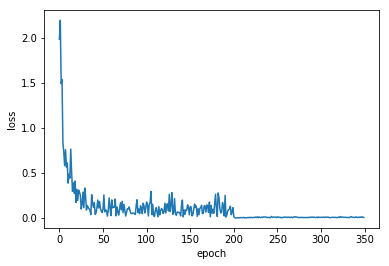

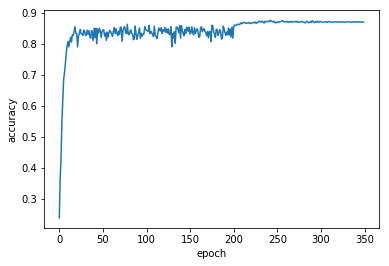

Best accuracy: 0.877



<Figure size 432x288 with 0 Axes>

In [9]:
lr_lst = [0.01]

fo = open("model_c.log", "w")
fo.write("Model C Trainning log\n")
fo.close()

for learning_rate in lr_lst:
    fo = open("model_c.log", "a")
    fo.write("\nOriginal Learning rate: {}\n".format(learning_rate))
    fo.close()
    print("Learning_rate:", learning_rate)
    model = Model(in_channel=3, channel_1=96, channel_2=192, 
             channel_3=192, channel_4=192, num_classes=10) 
    optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9, weight_decay=0.001)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                               milestones=[200, 250, 300], gamma=0.1)
    best_model = train(model, optimizer, scheduler, epochs=350, best_acc=0.0)
    print()

In [10]:
PATH = "../best_model/"
model_name = "best_model_c.pt"
if not os.path.exists(PATH):
    os.mkdir(PATH)
torch.save(best_model.state_dict(), PATH + model_name)